# Sturddle: A Chess Engine and Application

## Introduction
Sturddle is developed as a tool to explore and learn from the fields of Good Old-Fashioned Artificial Intelligence (GOFAI) and modern AI. The project uses chess, a domain with rich resources such as extensive literature, numerous existing engine implementations, and a vast array of training data, making it an effective medium for studying AI.
Sturddle is more than just a chess engine; it is a platform for experimenting with and understanding AI. The project uses chess as a practical tool to investigate both historical and modern approaches in AI, serving as a valuable learning and research medium in the field.

## Technical Composition
The Sturddle engine is a hybrid of C++, Cython, and Python, featuring various search algorithms including [MTD(f)](https://en.wikipedia.org/wiki/MTD(f)), [Negamax](https://en.wikipedia.org/wiki/Negamax), and [Negascout](https://en.wikipedia.org/wiki/Negascout). The default algorithm, MTD(f), is selected for its balance of efficiency and search depth.

### Unified Framework for Search Algorithms
The engine implements the above algorithms into one unified framework. This approach allows users to select the desired algorithm at runtime. While the MTD(f) algorithm is currently the most optimized, the presence of alternative algorithms offers potential for further exploration and research.

#### Example:
```
Sturddle UCI-2.00.010524.1525 AVX512/FMA
uci
id name Sturddle UCI-2.00.010524.1525
id author Cristian Vlasceanu
option name Algorithm type combo default mtdf var mtdf var negascout var negamax
option name Best Opening type check default false
option name Debug type check default false
option name Hash type spin default 32 min 16 max 1453
option name NNUEModel type string default 
option name OwnBook type check default true
option name Ponder type check default false
option name SyzygyPath type string default /home/cristian/Projects/syzygy/3-4-5
option name Threads type spin default 1 min 1 max 36
uciok
setoption name Algorithm value negascout
```

### C++ Core and Cython Integration
Originally developed using Python Chess, the engine has been iteratively and incrementally rewritten in C++. Its core, now in C++, is compiled into a Python module via Cython. This architecture combines the speed of C++ with the scriptability and flexibility of Python, which is particularly advantageous for testing and debugging. This transition from Python to C++ over time has allowed for fine-tuning and optimization while maintaining the ease of use provided by Python.

### Python Integration and Entry Points
The engine's entry points are located in the `__init__.pyx` module, enabling direct calls to functions like the search algorithm from Python. This design supports tight integration with the Chess App and allows for the creation of user-definable Python callbacks for troubleshooting and debugging purposes.

### UCI Implementations
Sturddle supports two Universal Chess Interface (UCI) implementations: a Python version and a C++ version in `uci_native.cpp`. The C++ implementation, requiring a C++20 compatible compiler, is selected when `NATIVE_UCI` is defined at compile time. This dual approach offers flexibility and optimizes performance across different platforms and environments.

## Standalone Executable and Multi-Architecture Support
In addition to its integration as a Python module, the Sturddle engine can also be built as a standalone executable using PyInstaller. This executable encapsulates all necessary Python scripts and resources, such as the opening book, into a single file. This feature is particularly useful for submitting the engine for testing to the Computer Chess Rating Lists (CCRL) or releasing it for use with other GUIs, like Cutechess and Arena.

### Building the "Fat" Multi-Architecture File
When packaged as a standalone executable, the engine is built with multi-architecture support. For example, the Intel/AMD build targets include SSE2, AVX2, and AVX512 Python modules. These are all bundled into the executable. A specialized "bootstrap" Python function is employed to detect the host architecture and import the appropriate module. This approach eliminates the need for runtime dispatching and ensures optimal performance.

### SSE/AVX2/AVX512 and Neural Net Inference
The SSE, AVX2, and AVX512 modules play a crucial role in neural net inference, as described in subsequent sections. Their inclusion in the standalone executable ensures that the engine leverages the full potential of the host hardware for maximum efficiency and speed.

## Neural Network Integration

### Evolution of Evaluation Methods in Chess Engines
Chess engines have undergone significant evolution in their evaluation methods. Traditionally, engines like early versions of Stockfish relied on hand-crafted evaluation functions, which involved manually programmed heuristics such as material balance, pawn structure, piece activity, and king safety. These methods, while effective for their time, had limitations in assessing complex positional plays.

In August 2020, a major development occurred when Stockfish 12 integrated the Efficiently Updatable Neural Network (NNUE). This integration marked a paradigm shift in engine evaluation strategies, moving away from purely heuristic-based evaluations to incorporating neural network-based approaches. The NNUE's advantage lay in its ability to understand complex positions without requiring GPU resources, a significant step forward in chess engine technology. The success of NNUE in Stockfish influenced other leading chess engines to adopt similar techniques, enhancing their positional understanding capabilities.

### Sturddle's Approach to Chess Evaluation
Sturddle, on the other hand, diverges from traditional chess engines by not using hand-crafted evaluation functions at all. Instead, it employs a simplified approach of using either a neural network-based evaluation or a material evaluation: If the material delta is large (the threshold is a tunable parameter), the delta value is used for evaluation; otherwise the neural-net (which requires more computational resources) is used instead. While not as powerful as established engines such as Stockfish, this makes Sturddle a strong-enough engine to experiment and develop with.

Interestingly, experimentation with incorporating piece-square table information into the material evaluation was conducted. However, this code is currently inactive (disabled) as it did not enhance the engine's performance. This experimentation highlights the ongoing process of development and the challenges faced in innovating chess engine technology.

The potential for future exploration in this area remains open. Revisiting the integration of piece-square tables with improved algorithms or neural network architectures could lead to further advancements in Sturddle's evaluation methods.

In its first iteration, Sturddle utilized the [NNUE Probe Library](https://github.com/dshawul/nnue-probe), leveraging NNUE models developed by the Stockfish Community. This version achieved an ELO rating of around 3070, as evaluated by the Computer Chess Rating Lists (CCRL).

The second version of Sturddle is enhanced with a neural network designed from the ground up and trained via a custom Tensorflow script. This version has shown improved performance in initial tests, though it has not yet been submitted for formal evaluation by the CCRL.

## Neural Network Training and Inference

### Training Data Sources
The neural network is trained on a diverse dataset encompassing games from Lichess, Leela Chess Zero, and games played by the Sturddle engine itself. Feeding data from the engine back into training serves as a form of reinforced learning.

### Training Environment and Dataset
Training is conducted on local Linux machines, with:
- A smaller dataset consisting of 6.5 billion moves.
- A larger dataset, currently at 14.5 billion moves.

Data is stored in HDF5 file format, optimizing the storage and retrieval processes.

### Feature Representation
The engine uses occupancy bitmaps for chess board representation, detailing 6 piece types for each color across 64 squares. This design facilitates the conversion of these bitmaps into neural network input features. The input layer comprises:
- 768 features for the occupancy bitmaps.
- 1 feature for the side to move.
- 128 additional features, derived by overparameterizing the occupancy masks for black and white, totaling 769 features.

### Loss Function and Data Filtering
- **Huber Loss Variation**: The training of the neural network utilizes a variation of the Huber loss function. This choice is due to its robustness in handling outliers, which is particularly useful in the diverse set of chess positions and evaluations.
- **Evaluation Range Filtering**: The training script includes a feature to filter out evaluations (Y values) beyond a certain range. By default, only evaluations within the range of [-15000, 15000] centipawns are used. This filtering helps focus the training on more typical game scenarios and avoids extreme cases that are less relevant for general gameplay

Details on the Loss Function design can be found [here](https://github.com/cristivlas/sturddle-2/blob/master/softclip.ipynb).

### Neural Network Tooling and Data Format

#### Toolkit for Data Preparation and Management
I have developed a set of small Python scripts for:
- Analyzing PGNs with a selected engine.
- Extracting training data from Lichess rated games.
- Converting training data from LCZ binpacks.
- Merging datasets and concatenating HDF5 files.
- Positional validation and de-duplication using Python Chess and sqlite3.
- Plot loss during training.

Some of these tools, while functional, present opportunities for performance improvements through parallelism, algorithmic enhancements, or potential C++ rewrites.

#### Advanced Data Storage with HDF5
The initial approach used numpy memory-mapped files, but due to the sparse nature of the data, this proved inefficient in terms of disk space and I/O speed. Now, the training data, formatted with one-bit-per-feature packed into 64-bit words, is stored in HDF5 files. This change significantly reduces disk usage and enhances I/O efficiency. Additionally, HDF5's 'virtual' file feature, which allows seamless handling of file collections by h5py, further optimizes data management. The unpacking of this compact format is efficiently handled on the GPU during training. For more on HDF5 and h5py, [visit the HDF5 website](https://www.hdfgroup.org/solutions/hdf5/) and [h5py documentation](https://www.h5py.org/).

#### TensorFlow Unpack Layer Implementation
```python
class UnpackLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs, **kwargs):
        super(UnpackLayer, self).__init__(**kwargs)
        self.num_outputs = num_outputs

    def call(self, packed):
        bitboards, turn = packed[:, :12], packed[:,-1:]
        f = tf.concat([tf_unpack_bits(bitboards), turn], axis=1)
        return tf.cast(f, tf.float32)

def tf_unpack_bits(bitboards):
    # Create a tensor containing bit positions [63, 62, ..., 0]
    bit_positions = tf.constant(list(range(63, -1, -1)), dtype=tf.uint64)
    bit_positions_exp = tf.reshape(bit_positions, [1, 1, 64])
    bitboards_exp = tf.expand_dims(bitboards, axis=-1)
    shifted = tf.bitwise.right_shift(bitboards_exp, bit_positions_exp)
    isolated_bits = tf.bitwise.bitwise_and(shifted, 1)
    return tf.reshape(isolated_bits, [-1, 12 * 64])
```

### Experimentation with Training Parameters
- **Filter and Delta Values**: Ongoing experiments are being conducted to find optimal values for both the filter threshold and the delta parameter of the Huber loss function. For instance, one effective version of the network was trained with a delta of 3.0 and a filter threshold of 1500 centipawns.
- **Current Training Runs**: Training runs with varying filter and delta values are underway to evaluate their impact on the network's performance and learning efficiency.

### Network Fine-Tuning
- **Selective Freezing of Network Layers**: Modifications have been made to the training script to allow parts of the neural network to be "frozen." This technique enables fine-tuning of the network, where specific layers are fixed, and learning is focused on other parts of the network. This approach is beneficial for refining the network's performance based on previous learning while adapting to new data or strategies.

These enhancements and experiments reflect a continuous effort to optimize the neural network's performance for chess analysis and decision-making. The ongoing training and adjustments are aimed at achieving a balance between accuracy, generalization, and computational efficiency.

### Inference
In line with techniques used in NNUE (Neural Networks Updated Efficiently), my inference process takes advantage of the binary nature of input features (0 or 1) and the minimal changes introduced by chess moves. This allows for the incremental computation of the first layer of the neural network, rather than full dot products for each move. I maintain a stack of states during the alpha-beta graph search, with individual stacks for each core to avoid race conditions.

### CPU-Only Inference for Wide Compatibility
Inference is implemented in C++ for CPU-only execution, ensuring compatibility with low-end Android devices. The implementation makes use of:
- Agner Fog's VCL2 ([GitHub Repository](https://github.com/vectorclass/version2))
- simde ([GitHub Repository](https://github.com/simd-everywhere/simde))
- Custom NEON code to optimize performance with `__ARM_FEATURE_FP16_VECTOR_ARITHMETIC` where available.

## Other Machine Learning Tools and Methodologies

### Optimization Tools
The engine contains several heuristics such as futility pruning, that are controlled by internal parameters. The following machine learning tools are used for tuning the various internal parameters:
- A script based on Nevergrad is used for optimizing engine parameters. [Lakas](https://github.com/fsmosca/Lakas)
- A Bayesian tuner is employed for fine-tuning one or two-dimensional parameters. [Chess Tuning Tools Documentation](https://chess-tuning-tools.readthedocs.io/en/latest/).

### UCI Integration and Tuning Mode
When compiled in tuning mode, the engine exposes its internal parameters to the Universal Chess Interface (UCI). In the release mode, these parameters are set as compile-time constants. This dual-mode functionality allows for extensive testing and optimization during development.

Example of tuning run:
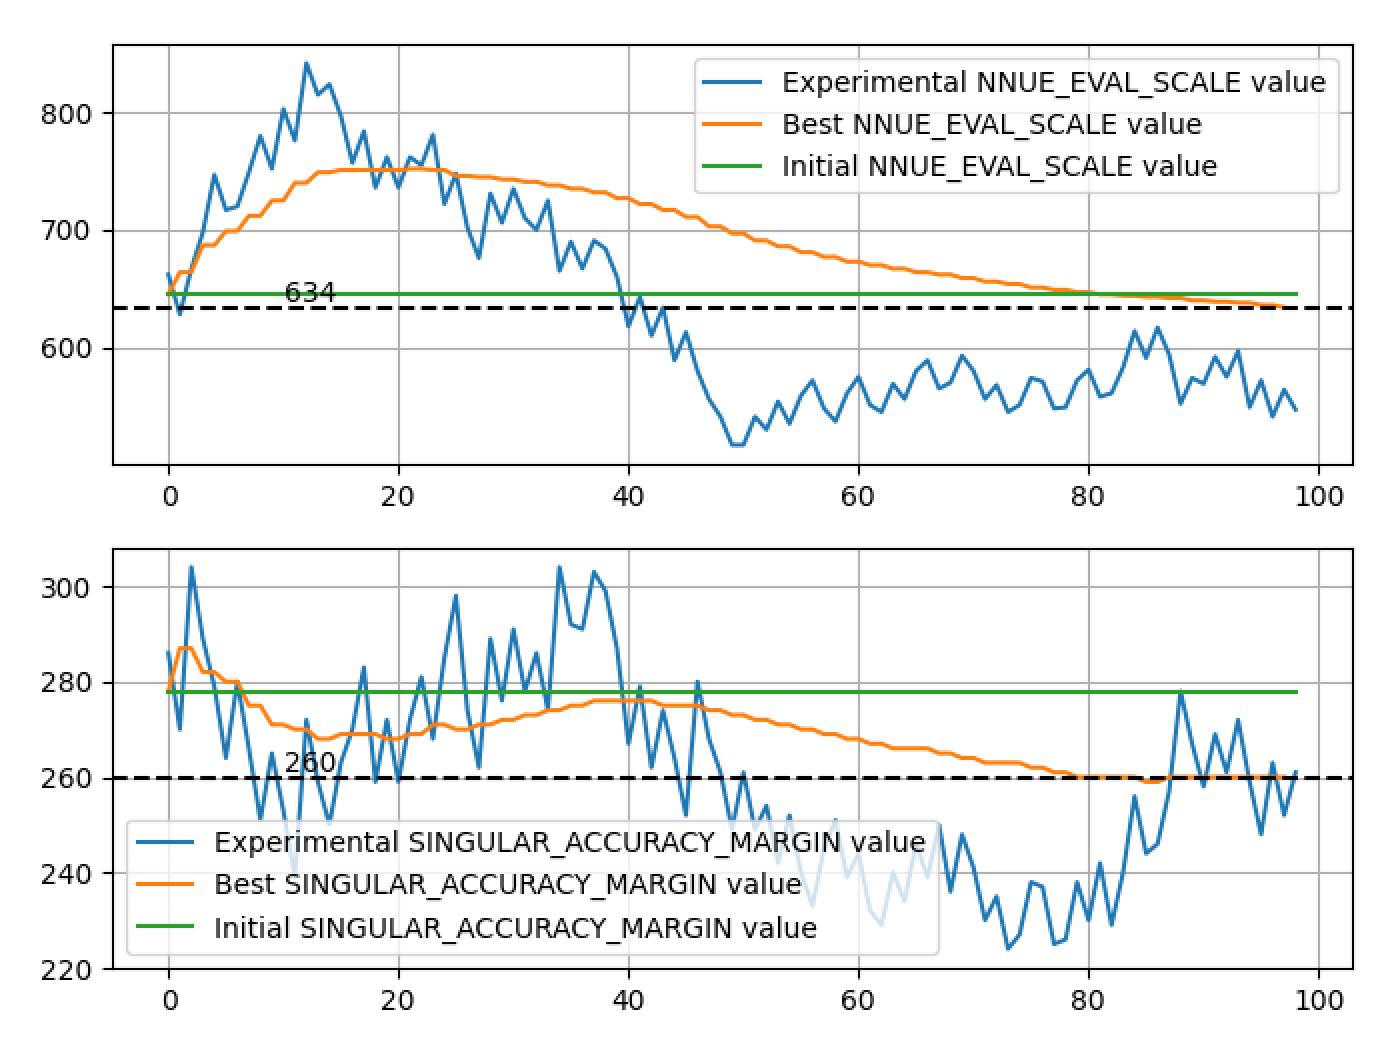

### Data Collection for Reinforced Learning
During tuning runs, there is an option to enable data collection. Evaluations from the neural network, particularly from the winning perspective, are collected and fed back into the training process. This approach reinforces the learning capabilities of the neural network.

## Training Methodology and Architecture

### Experimentation with Perspective-Based Training
I have experimented with training the neural network on values from the perspective of the side-to-move, yielding reasonable results. The current architecture in development, however, is trained on ground truth evaluations from the white player's perspective. These evaluations are switched post-inference at runtime.

### Network Architecture
The neural network features two distinct paths:
- The main path includes an averaging pooling layer, which aids in reducing dimensionality and smoothing outliers.
- A secondary path focuses on features representing pawns and kings. These pieces encapsulate implicit information about game phases. After processing through two layers, the results are multiplied with the outputs from the first layer of the main network path.

![Model Architecture](model.png)

The weights from the training process in the Sturddle chess engine can be exported and imported in two ways. Firstly, at compile time, the training script provides an option to export weights as C++ code snippets, suitable for modern compilers. Secondly, at runtime, weights can be exported as JSON, and the engine includes a custom UCI command for importing them. This flexibility enables efficient weight handling during engine development and deployment.

## Testing and Quality Assurance

### Unit Testing in Python
Unit tests in Python focus on specific functional areas of the engine. These tests ensure component integrity and help in early detection of issues.

### Chess Puzzle Test Suite
The engine undergoes testing with chess puzzles from collections like WAC and ERET. Although the engine doesn't solve every puzzle in these sets, this approach is valuable for detecting regressions and maintaining consistent performance. ERET tests the engine's ability to find solutions quickly, which is useful for benchmarking ([ERET on Chessprogramming wiki](https://www.chessprogramming.org/Eigenmann_Rapid_Engine_Test)).

### Tournament-Style Engine Testing
Using the standalone executable, the engine competes in matches and tournaments with other engines, including its own previous versions, through GUIs like Arena and Cutechess. This tests its strategic capabilities and checks for stability in various scenarios.

## App Overview
The Sturddle Chess App, designed for Android phones and tablets and also compatible with desktops, is an educational and interactive chess platform. Developed using Kivy and Python Chess, it caters to entry-level students and those seeking to play and study chess. The app's GitHub repository can be found at [Sturddle Chess App on GitHub](https://github.com/cristivlas/sturddle-chess-app).

## Key Features

- **Built-in Board Editor**: Users can set up and modify chess positions, aiding in learning and experimentation.
- **AI Toggle**: The app allows players to engage with the AI or opt for manual game study.
- **PGN Support**: It supports Portable Game Notation (PGN) for game import, export, and sharing, complete with rendering of annotations for in-depth analysis.
- **Voice Interaction**: Offers voice command capabilities, including offline speech recognition on desktop via OpenAI Whisper, for a hands-free experience.
- **Optional Opening Books**: Players have the option to use various opening books, assisting in the exploration of different chess strategies.
- **Encyclopedia of Chess Openings (ECO) Database**: Features the ECO database, sourced from [Lichess.org](https://github.com/lichess-org/chess-openings), providing a systematic study of chess openings.
- **Puzzle Collection**: A selection of chess puzzles from the [Lichess Puzzle Database](https://database.lichess.org/#puzzles) is included to improve tactical skills.
- **Difficulty Levels and CPU Core Utilization**: The app features 9 levels of difficulty, catering to a wide range of skill levels. On the highest level, users can increase the engine's power by allocating more CPU cores, limited only by the device's capabilities.

## Target Audience and Functionality
The Sturddle Chess App is tailored for beginners and those new to chess, providing a conducive environment for learning and improvement. Notably, the app does not include time controls, focusing instead on a relaxed and educational gameplay experience.




## Assistant Feature

### Overview
The "Assistant" feature in the Sturddle Chess App is a tool that integrates the OpenAI API's function-calling capabilities, offering users a sophisticated AI partner to assist with their chess learning and playing. It enables users to interact with the app through natural language queries and commands.

### Configuration
The feature's settings allow users to:

- **Enter the OpenAI Key**: A necessary step to access the OpenAI API's functionalities.
- **Toggle Assistant**: Switch the Assistant on or off according to the user's preference.
- **Select Model**: Choose the OpenAI model for the desired balance between speed and complexity.
- **Set Endpoint URL**: The API endpoint where the Assistant sends requests.
- **Adjust Max Retry Count**: The number of attempts the Assistant makes after a failed request.
- **Set Temperature**: Modulate the predictability or diversity of the Assistant's responses.
- **Define Initial Timeout**: The wait time for a response before the Assistant times out.

### Interactive Capabilities
The Assistant can:

- Answer queries about chess openings, like explaining variants of the Sicilian Defense, and then act on follow-up commands to play a specific variant on the board or show perspectives.
- Recommend moves, comment on the current game, or assess who is ahead in a given position. For these functionalities, the Assistant interacts with the chess engine for real-time analysis.
- Respond to requests for practice scenarios, such as "checkmate in 3" or studying specific endgames. The Assistant selects appropriate puzzles from the built-in collection to match the user's query.

### Integration and Usage
Users must have an active OpenAI subscription to access the Assistant. By entering their API key, they can leverage the Assistant to enhance their chess training. Whether it's to learn new openings, analyze ongoing games, or practice specific scenarios, the Assistant serves as an on-demand coach and companion.

The Assistant is integrated with the voice command system, utilizing a grammar framework based on the `pyparsing` library for recognizing simple spoken commands such as chess moves or opening names. This setup allows for immediate interpretation and execution of basic commands derived from speech-to-text input.

- **Simple Grammar with pyparsing**: A tool that simplifies the development of parsers to interpret voice commands.
- **Voice Commands**: Recognizes and executes basic commands related to chess gameplay.

### Fallback to OpenAI API
When local command recognition is insufficient, the system escalates unrecognized commands to the OpenAI API, provided the Assistant is enabled. This ensures that the app maintains functionality even when local parsing is unsuccessful.

### Opening Names Lookup with Fuzzy and Phonetic Matching
To handle the variability in opening name pronunciation, the app uses `rapidfuzz` for fuzzy string matching and `metaphone` for phonetic matching.

- **rapidfuzz**: Implements fast string matching to accommodate for slight variations in opening name input.
- **Phonetic Matching with metaphone**: Helps match similar-sounding words despite differences in spelling, accent, or audio quality.

### Local Processing Advantage
The decision to process chess-specific tasks locally is informed by the limitations of the ChatGPT model's understanding of complex chess opening details and its inability to visualize chess positions internally.

- **Local Chess Engine**: Utilizes the in-built chess engine for accurate and efficient chess-related processing, bypassing the limitations of cloud-based NLP in understanding detailed chess information.

These technical design choices showcase a comprehensive approach to creating an effective, efficient, and user-friendly Assistant feature within the Sturddle Chess App.

## Watch the Assistant in Action

For visual demonstrations of the Sturddle Chess App's Assistant feature, you can watch the following YouTube videos:

- [Video 1](https://youtu.be/17QLxjuZvpo)
- [Video 2](https://youtu.be/_Mna8cYUTz0)

### Assistant Feature: Interaction Workflow and Exploration of Alternatives

The "Assistant" feature in the Sturddle Chess App integrates the OpenAI API's function-calling capabilities for chess learning and playing. This feature enables interaction through natural language queries and commands.

#### Current Interaction Workflow with OpenAI API

   - User inputs are initially processed by the app. Inputs not handled locally are sent to the OpenAI API, along with the prompt.
   - The OpenAI models determine if a function call back to the app is necessary based on the user input and the provided context.
   - The app executes the required function locally and captures the result.
   - The result and context are sent back to OpenAI for further processing.
   - OpenAI processes the new input to render the final output, completing the interaction cycle.

![Sturddle Assistant Workflow](sturddle_assistant_workflow.png)

This workflow involves two round trips to the OpenAI API. To optimize this process, an alternative approach using a local vector store was explored.

#### Exploration of Alternative Approaches: Local Vector Store
The alternative approach considered using local vector store technologies such as [Qdrant](https://github.com/qdrant/qdrant) with Fast Embeddings and [Vectordb](https://github.com/kagisearch/vectordb) over Faiss:

- **Proposed Workflow:**
  - User inputs would be processed against a local vector database to recognize intent and generate the relevant context.
  - The locally retrieved openings, analysis or puzzles are sent back as context to OpenAI together with a prompt template.

- **Reasons for Not Proceeding:**
  - Increased dependency overhead, complicating development (deploying all required components to Android gets tricky).
  - Resource requirements deemed excessive for low-end Android devices, potentially impacting performance.

#### Current Implementation
A simplifed approach based on the Annoy algorithm (https://github.com/spotify/annoy) turned out to be effective:
A local IntentClassifier uses the BytePairEnconding scheme to tokenize strings, and places them in a vector space using Annoy.
The classifier is trained by an ad-hoc script that generates synthetic data from the opening names and from puzzle themes built into the app.
The tokenized data is run through an TF-IDF model before constructing the Annoy index.

A similar technique is used for fuzzy searches of openings, except that the vector space is generated by running the tokenized opening names through an embedding layer. The embedding layer is generated by training a CBOW (Continuous Bag of Words) model with TF-IDF weighting and positional encodings. At inference time the model is not needed, and thus there's no need to deploy a TensorFlow, TensorFlow Lite or PyTorch framework (they tend to have complicated dependencies!) with the Android app. The numpy serialized embedding matrix suffices. To correct any possible errors due to Annoy searches (A stands for Approximate!) a RapidFuzz (https://pypi.org/project/rapidfuzz/) pass is done on the candidate results. This approach seems to provide accurate enough results with good performance even on lower end devices. 

Both the IntentClassifier and the search of chess openings described above use an intermediate step of post-processing tokens via the metaphone algorithm. This improves the search resilience for chess openings named after foreign chessmaster in situations where either the user misspells the names or the Speech to Text translation introduces errors.

### Conclusion on Technical Design Choices
The exploration of these alternatives highlights the importance of balancing technical capabilities with practical constraints like device capabilities and user experience. The decision to continue with the current cloud-based approach, while keeping local processing streamlined, aligns with the goal of maintaining optimal performance on low-end devices.
